In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, Imputer, VectorAssembler, PCA
from pyspark.sql.functions import count, when, col, mean, median, expr, skewness
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
import pandas as pd
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
import numpy as np

In [ ]:
spark = SparkSession.builder.appName("Kmeans").getOrCreate()

In [ ]:
file_path = "/content/pca_data.csv"

In [ ]:
#data = spark.read\
 #     .format("csv") \
  #    .option("header","true") \
   #   .option("inferSchema","true") \
    #  .option("sep",";") \
     # .load(file_path)

In [ ]:
data = spark.read.csv(file_path,  header=True, inferSchema=True)

In [ ]:
display(data.describe())

DataFrame[summary: string, pc1: string, pc2: string, pc3: string]

In [ ]:
data.show()

+--------------------+--------------------+--------------------+
|                 pc1|                 pc2|                 pc3|
+--------------------+--------------------+--------------------+
|  -4.688990298591092|-0.16105958191953332|  -2.150476906920061|
|    2.84303512991608| -0.1970286837025931|   2.047757826841097|
|  -2.508281353080828|  0.8519421916573712|  0.1633727577626868|
|  2.6546251428541296|  1.5369548861577003|-0.17990356347302514|
|  0.5523046199295245|0.049763351943901864|-0.46180293345613815|
| -0.6374425640296506|  -1.260896850240662|   0.737590414865381|
| -0.5705616469595954| -1.5587626451210113| -0.8541243963699584|
|  2.3958492591218414|  0.8991361813361359|  -1.496119462970719|
|  2.9725888006414487|   1.231300543824599|   -0.94458668557022|
|   5.042755804708938| -0.5893718703335132| -0.6478469358086255|
|  1.7261751586803042|  2.6121183140028776| -1.6426821942362355|
| -3.8988822815360495|  1.9486847297964611|  0.7244371358938236|
|  1.7889389862045233| -1

In [ ]:
data.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                 pc1|                 pc2|                 pc3|
+-------+--------------------+--------------------+--------------------+
|  count|                2212|                2212|                2212|
|   mean|8.331691776120071...|1.485651063693699...|6.566226365125954...|
| stddev|   2.814810602745994|  1.6165138112305295|  1.2113973832221085|
|    min|   -7.51614580978999|  -5.600904884045589|  -5.982727814930029|
|    max|   5.694811654471698|  3.7192861019498094|  3.4281694046819537|
+-------+--------------------+--------------------+--------------------+



In [ ]:
X = data.toPandas()
X = X.to_numpy()
print(X)

[[-4.6889903  -0.16105958 -2.15047691]
 [ 2.84303513 -0.19702868  2.04775783]
 [-2.50828135  0.85194219  0.16337276]
 ...
 [-2.26163591  1.47779129 -0.132783  ]
 [-1.6869513  -1.28142522  1.86052311]
 [ 2.39267063 -1.44981072  0.12050551]]


In [ ]:

# Khởi tạo các centroid ngẫu nhiên từ dữ liệu X
def centroids_init(X,k):
  indices = np.random.choice(X.shape[0],k,replace = False)
  return X[indices]

Sử dụng công thức Euclidean trong không gian 3 chiều

In [ ]:
# Gán điểm dữ liệu vào centroid gần nhất
def assign_clusters(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

In [ ]:
# Tạo hàm cập nhật centroids
def update_centroids(X,centroids,k):
  new_centroids = []
  for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:  # Kiểm tra cụm rỗng
            new_centroids.append(X[np.random.choice(X.shape[0])])  # Thay thế bằng một điểm ngẫu nhiên từ dữ liệu
        else:
            new_centroids.append(cluster_points.mean(axis=0))
  return np.array(new_centroids)

In [ ]:
# Tính WCSS
def calculate_wcss(X,labels,centroids):
  wcss = 0
  for i in range(centroids.shape[0]):
    cluster_points = X[labels == i]
    wcss += ((cluster_points - centroids[i])**2).sum()
  return wcss

In [ ]:
#Tạo thuật toán K-means
def kmeans(X, k, max_iters=100, tol=1e-4):
    centroids = centroids_init(X, k)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    wcss = calculate_wcss(X, labels, centroids)
    return centroids, labels, wcss

In [ ]:


# Phạm vi các giá trị k
k_values = list(range(2, 11))
wcss = []

# Chạy KMeans cho từng giá trị k
for k in k_values:
    centroids, labels, cost = kmeans(X, k)
    wcss.append(kmeans(X,k)[2])
    print( k," cluster have wcss: ", kmeans(X,k)[2])

2  cluster have wcss:  12907.469816085646
3  cluster have wcss:  10816.890650027808
4  cluster have wcss:  8465.186573066727
5  cluster have wcss:  6294.272949720877
6  cluster have wcss:  5743.312772817052
7  cluster have wcss:  5220.76370135969
8  cluster have wcss:  4827.247059310924
9  cluster have wcss:  4457.089755181393
10  cluster have wcss:  4220.291900803495


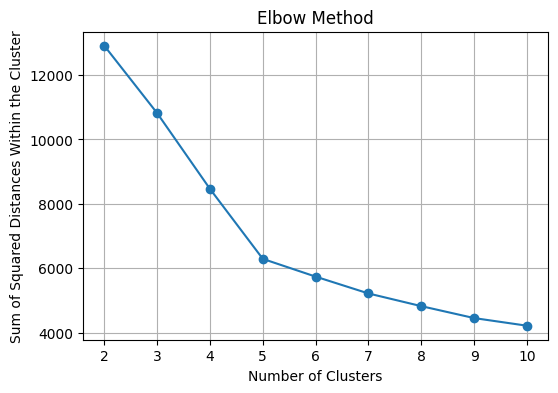

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances Within the Cluster")
plt.title("Elbow Method")
plt.grid(True)

plt.show()

Khuỷu nằm ở 5
vậy K=5 là phù hợp nhất

In [ ]:
#Chạy K-Means 1 lần nữa với k = 5
centroids, labels, cost = kmeans(X, 5)



In [ ]:
def plot_clusters_3d(X, centroids, labels):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'y','orange']

    # Vẽ các điểm dữ liệu theo từng cụm
    for label in range(len(centroids)):
        ax.scatter(X[labels == label, 0], X[labels == label, 1], X[labels == label, 2],
                   c=colors[label], marker='o', label=f'Cluster {label}')

    # Vẽ các tâm cụm
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
               marker='x', s=200, c='black', label='Centroids')

    # Đặt nhãn cho các trục
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

    # Hiển thị chú thích
    ax.legend()

    # Hiển thị biểu đồ
    plt.title('Biểu đồ 3D của các cụm')
    plt.show()


In [ ]:
clusters = kmeans(X,5)[1]
# Lấy các giá trị duy nhất trong mảng NumPy
unique_clusters = np.unique(clusters)

# Hiển thị các giá trị duy nhất trong cột 'cluster'
print(unique_clusters)

[0 1 2 3 4]


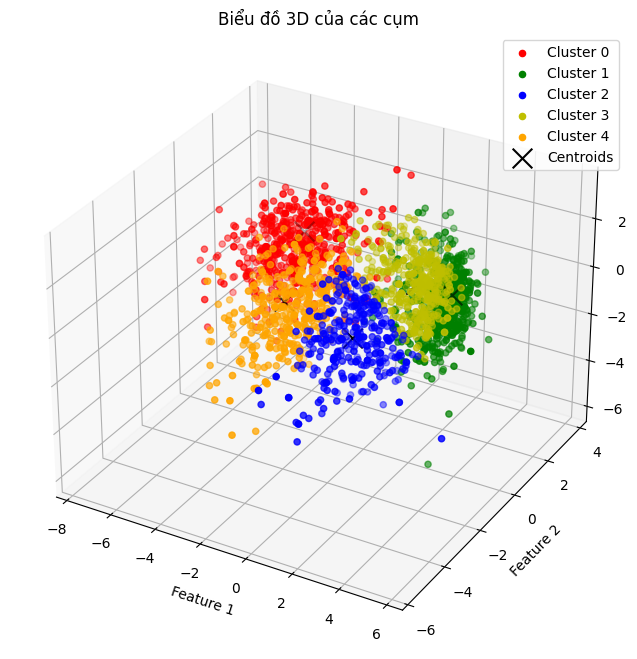

In [ ]:
plot_clusters_3d(X, kmeans(X,5)[0], kmeans(X,5)[1])

In [ ]:
data = spark.read.csv("/content/data_fixed.csv", header=True, inferSchema=True)

In [ ]:
data.describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+-------------------+
|summary|           Income|            Kidhome|          Teenhome|           Recency|             Wines|            Fruits|              Meat|             Fish|            Sweets|             Gold|NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       CustomerFor|               Age|      Total_Spent|          Children|          Is_Parent|         Education|        Living_With|
+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+--------

In [ ]:
# Chuyển labels thành DataFrame
labels_df = spark.createDataFrame([(int(label),) for label in kmeans(X,5)[1]], ["cluster"])
# Hiển thị cấu trúc của DataFrame data
print("Cấu trúc của DataFrame data:")
data.printSchema()

# Hiển thị cấu trúc của DataFrame labels_df
print("Cấu trúc của DataFrame labels_df:")
labels_df.printSchema()

# Thêm cột cluster vào df
#labels_df = labels_df.withColumnRenamed("cluster", "cluster")
#data = data.withColumn("cluster", labels_df["cluster"])

# Hiển thị df với cột cluster mới
#data.show()

Cấu trúc của DataFrame data:
root
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Wines: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Meat: integer (nullable = true)
 |-- Fish: integer (nullable = true)
 |-- Sweets: integer (nullable = true)
 |-- Gold: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- CustomerFor: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Spent: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Is_Parent: integer (nullable = true)
 |-- Education: double (nullable = true)
 |-- Living_With: double (nullable = true)
 |-- index: long (nullable = false)

C

In [ ]:
labels_df.describe().show()

+-------+------------------+
|summary|           cluster|
+-------+------------------+
|  count|              2212|
|   mean|1.8273056057866184|
| stddev|1.4256852227346881|
|    min|                 0|
|    max|                 4|
+-------+------------------+



In [ ]:
labels_df.show()

+-------+
|cluster|
+-------+
|      0|
|      3|
|      0|
|      1|
|      2|
|      4|
|      4|
|      1|
|      1|
|      1|
|      1|
|      0|
|      3|
|      1|
|      0|
|      3|
|      1|
|      4|
|      1|
|      1|
+-------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Thêm một cột index vào DataFrame `data`
data = data.withColumn("index", monotonically_increasing_id())

# Thêm một cột index vào DataFrame `labels_df`
labels_df = labels_df.withColumn("index", monotonically_increasing_id())

# Sử dụng hàm join để kết hợp `data` và `labels_df` dựa trên cột index
data = data.join(labels_df, on="index", how="inner")

# Loại bỏ cột index không cần thiết
data = data.drop("index")

# Hiển thị 10 dòng đầu tiên của DataFrame `data`
data.show(10)


+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+-----------+---+-----------+--------+---------+---------+-----------+-------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|CustomerFor|Age|Total_Spent|Children|Is_Parent|Education|Living_With|cluster|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+-----------+---+-----------+--------+---------+---------+-----------+-------+
| 58138|      0|       0|     58|  635|    88| 546| 172|    88|  88|                3|              8|                 10|                4|                7|        663| 67|       1617|       0|        0|      0.0|        1.0|      0|
| 46344|      1|       1|     38|   11|     1|   6|   2|